In [1]:
import SimpleITK as sitk
import numpy as np
from pathlib import Path
from PIL import Image
import os
import pandas as pd
from radiomics import featureextractor
from scipy.stats import pointbiserialr

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # 设置图像清晰度为 retina 级别

# import gui
import ipywidgets as widgets
from IPython.display import display


In [2]:
def loadDcm(dcm_path: Path):
    """
    load dicom files from dcm_path(folder), return (ndarray, sitk.Image)
    """
    # 使用SimpleITK读取DICOM文件夹
    series_reader = sitk.ImageSeriesReader()
    series_reader.MetaDataDictionaryArrayUpdateOn()
    series_reader.LoadPrivateTagsOn()
    dicom_series = series_reader.GetGDCMSeriesFileNames(str(dcm_path))
    series_reader.SetFileNames(dicom_series)
    ct_image = series_reader.Execute()

    # 将SimpleITK图像转换为NumPy数组
    ct_ndarray = sitk.GetArrayFromImage(ct_image)

    return ct_ndarray, ct_image

In [3]:
def laodMask(mask_path: Path):
    """
    load png files from mask_path(folder), return (ndarray)
    """

    # 获取文件夹中所有PNG文件的文件名
    mask_path = str(mask_path)
    png_files = sorted([f for f in os.listdir(mask_path) if f.endswith(".png")])

    # 通过循环读取PNG文件序列并存储在列表中
    mask_sequence = []
    for png_file in png_files:
        png_path = os.path.join(mask_path, png_file)
        image = Image.open(png_path)
        mask_sequence.append(image)

    masks = np.stack([np.array(image) for image in mask_sequence[::-1]])
    return masks

In [4]:
class MultiImageDisplay(object):

    def __init__(
        self,
        patient,
        image_list,
        axis=0,
        shared_slider=False,
        title_list=None,
        window_level_list=None,
        intensity_slider_range_percentile=[2, 98],
        figure_size=(10, 8),
        horizontal=True,
    ):

        self.patient, self.image_list, self.horizontal, self.figure_size = patient, image_list, horizontal, figure_size

        self.npa_list, wl_range, wl_init = self.get_window_level_numpy_array(
            image_list, window_level_list, intensity_slider_range_percentile
        )
        if title_list:
            if len(image_list) != len(title_list):
                raise ValueError("Title list and image list lengths do not match")
            self.title_list = list(title_list)
        else:
            self.title_list = [""] * len(image_list)

        # Our dynamic slice, based on the axis the user specifies
        self.slc = [slice(None)] * 3
        self.axis = axis

        ui = self.create_ui(shared_slider, wl_range, wl_init)
        display(ui)

        if len(image_list) == 1:
            self.axes = [self.axes]

        # Display the data and the controls, first time we display the image is outside the "update_display" method
        # as that method relies on the previous zoom factor which doesn't exist yet.
        self.update_display()

    def create_ui(self, shared_slider, wl_range, wl_init):
        # Create the active UI components. Height and width are specified in 'em' units. This is
        # a html size specification, size relative to current font size.

        if shared_slider:
            # Validate that all the images have the same size along the axis which we scroll through
            sz = self.npa_list[0].shape[self.axis]
            for npa in self.npa_list:
                if npa.shape[self.axis] != sz:
                    raise ValueError(
                        "Not all images have the same size along the specified axis, cannot share slider."
                    )

            slider = widgets.IntSlider(
                description="image slice:",
                min=0,
                max=sz - 1,
                step=1,
                value=int((sz - 1) / 2),
                width="20em",
            )
            slider.observe(self.on_slice_slider_value_change, names="value")
            self.slider_list = [slider] * len(self.npa_list)
            slicer_box = widgets.Box(padding=7, children=[slider])
        else:
            self.slider_list = []
            for npa in self.npa_list:
                slider = widgets.IntSlider(
                    description="image slice:",
                    min=0,
                    max=npa.shape[self.axis] - 1,
                    step=1,
                    value=int((npa.shape[self.axis] - 1) / 2),
                    width="20em",
                )
                slider.observe(self.on_slice_slider_value_change, names="value")
                self.slider_list.append(slider)
            slicer_box = widgets.Box(padding=7, children=self.slider_list)
        self.wl_list = []
        # Each image has a window-level slider, but it is disabled if the image
        # is a color image len(npa.shape)==4 . This allows us to display both
        # color and grayscale images in the same UI while retaining a reasonable
        # layout for the sliders.
        for r_values, i_values, npa in zip(wl_range, wl_init, self.npa_list):
            wl_range_slider = widgets.IntRangeSlider(
                description="intensity:",
                min=r_values[0],
                max=r_values[1],
                step=1,
                value=[i_values[0], i_values[1]],
                width="20em",
                disabled=len(npa.shape) == 4,
            )
            wl_range_slider.observe(self.on_wl_slider_value_change, names="value")
            self.wl_list.append(wl_range_slider)
        wl_box = widgets.Box(padding=7, children=self.wl_list)
        return widgets.VBox(children=[slicer_box, wl_box])

    def get_window_level_numpy_array(
        self, image_list, window_level_list, intensity_slider_range_percentile
    ):
        # Using GetArray and not GetArrayView because we don't keep references
        # to the original images. If they are deleted outside the view would become
        # invalid, so we use a copy which guarantees that the GUI is consistent.
        npa_list = list(map(sitk.GetArrayFromImage, image_list))

        wl_range = []
        wl_init = []
        # We need to iterate over the images because they can be a mix of
        # grayscale and color images. If they are color we set the wl_range
        # to [0,255] and the wl_init is equal, ignoring the window_level_list
        # entry.
        for i, npa in enumerate(npa_list):
            if len(npa.shape) == 4:  # color image
                wl_range.append((0, 255))
                wl_init.append((0, 255))
                # ignore any window_level_list entry
            else:
                # We don't necessarily take the minimum/maximum values, just in case there are outliers
                # user can specify how much to take off from top and bottom.
                min_max = np.percentile(
                    npa.flatten(), intensity_slider_range_percentile
                )
                wl_range.append((min_max[0], min_max[1]))
                if not window_level_list:  # No list was given.
                    wl_init.append(wl_range[-1])
                else:
                    wl = window_level_list[i]
                    if wl:
                        wl_init.append((wl[1] - wl[0] / 2.0, wl[1] + wl[0] / 2.0))
                    else:  # We have a list, but for this image the entry was left empty: []
                        wl_init.append(wl_range[-1])
        return (npa_list, wl_range, wl_init)

    def on_slice_slider_value_change(self, change):
        self.update_display()

    def on_wl_slider_value_change(self, change):
        self.update_display()

    def update_display(self):

        # 创建新的子图对象
        col_num, row_num = (len(self.image_list), 1) if self.horizontal else (1, len(self.image_list))
        self.fig, self.axes = plt.subplots(row_num, col_num, figsize=self.figure_size)

        # Draw the image(s)
        for ax, npa, title, slider, wl_slider, in zip(
            self.axes, self.npa_list, self.title_list, self.slider_list, self.wl_list,
        ):
            # We want to keep the zoom factor which was set prior to display, so we log it before
            # clearing the axes.

            self.slc[self.axis] = slice(slider.value, slider.value + 1)
            # Need to use squeeze to collapse degenerate dimension (e.g. RGB image size 124 124 1 3)
            ax.imshow(
                np.squeeze(npa[tuple(self.slc)]),
                cmap=plt.cm.Greys_r,
                vmin=wl_slider.value[0],
                vmax=wl_slider.value[1],
            )
            ax.set_title(f"{self.patient} patient {slider.value} layer {title}")
            ax.set_axis_off()


        self.fig.canvas.draw_idle()
        plt.tight_layout()

In [5]:
def Mydisplay(patient, ct_Image, mask_Image):

    ct_Image = sitk.Cast(
        sitk.IntensityWindowing(
            ct_Image,
            windowMinimum=-1000,
            windowMaximum=170,
            outputMinimum=0.0,
            outputMaximum=255.0,
            ),
        sitk.sitkUInt8,
    )
    
    half_overlap = sitk.LabelOverlay(
            image=ct_Image,
            labelImage=mask_Image,
            opacity=0.3,
            backgroundValue=0,
        )

    zeros = sitk.Image(ct_Image.GetSize(), ct_Image.GetPixelID())
    zeros.CopyInformation(ct_Image)

    half_ct = sitk.LabelOverlay(
            image=ct_Image,
            labelImage=zeros,
            opacity=0.3,
            backgroundValue=0,
        )
    
    MultiImageDisplay(
        patient=patient,
        # image_list=[half_ct, mask_Image, sitk.LabelToRGB(mask_Image), half_overlap],      # use black/white mask as second picture
        image_list=[half_ct, sitk.LabelToRGB(mask_Image), half_overlap],
        title_list=["original image", "segmentation labels", "fuse image"],
        figure_size=(18, 18),
        shared_slider=True,
        axis=0,
    )


patient: 1, 	ct shape: (96, 512, 512), 	mask shape: (96, 512, 512)


patient: 10, 	ct shape: (110, 512, 512), 	mask shape: (110, 512, 512)


patient: 14, 	ct shape: (95, 512, 512), 	mask shape: (95, 512, 512)


patient: 16, 	ct shape: (91, 512, 512), 	mask shape: (91, 512, 512)


patient: 18, 	ct shape: (111, 512, 512), 	mask shape: (111, 512, 512)


patient: 19, 	ct shape: (90, 512, 512), 	mask shape: (90, 512, 512)


patient: 2, 	ct shape: (81, 512, 512), 	mask shape: (81, 512, 512)


KeyboardInterrupt: 

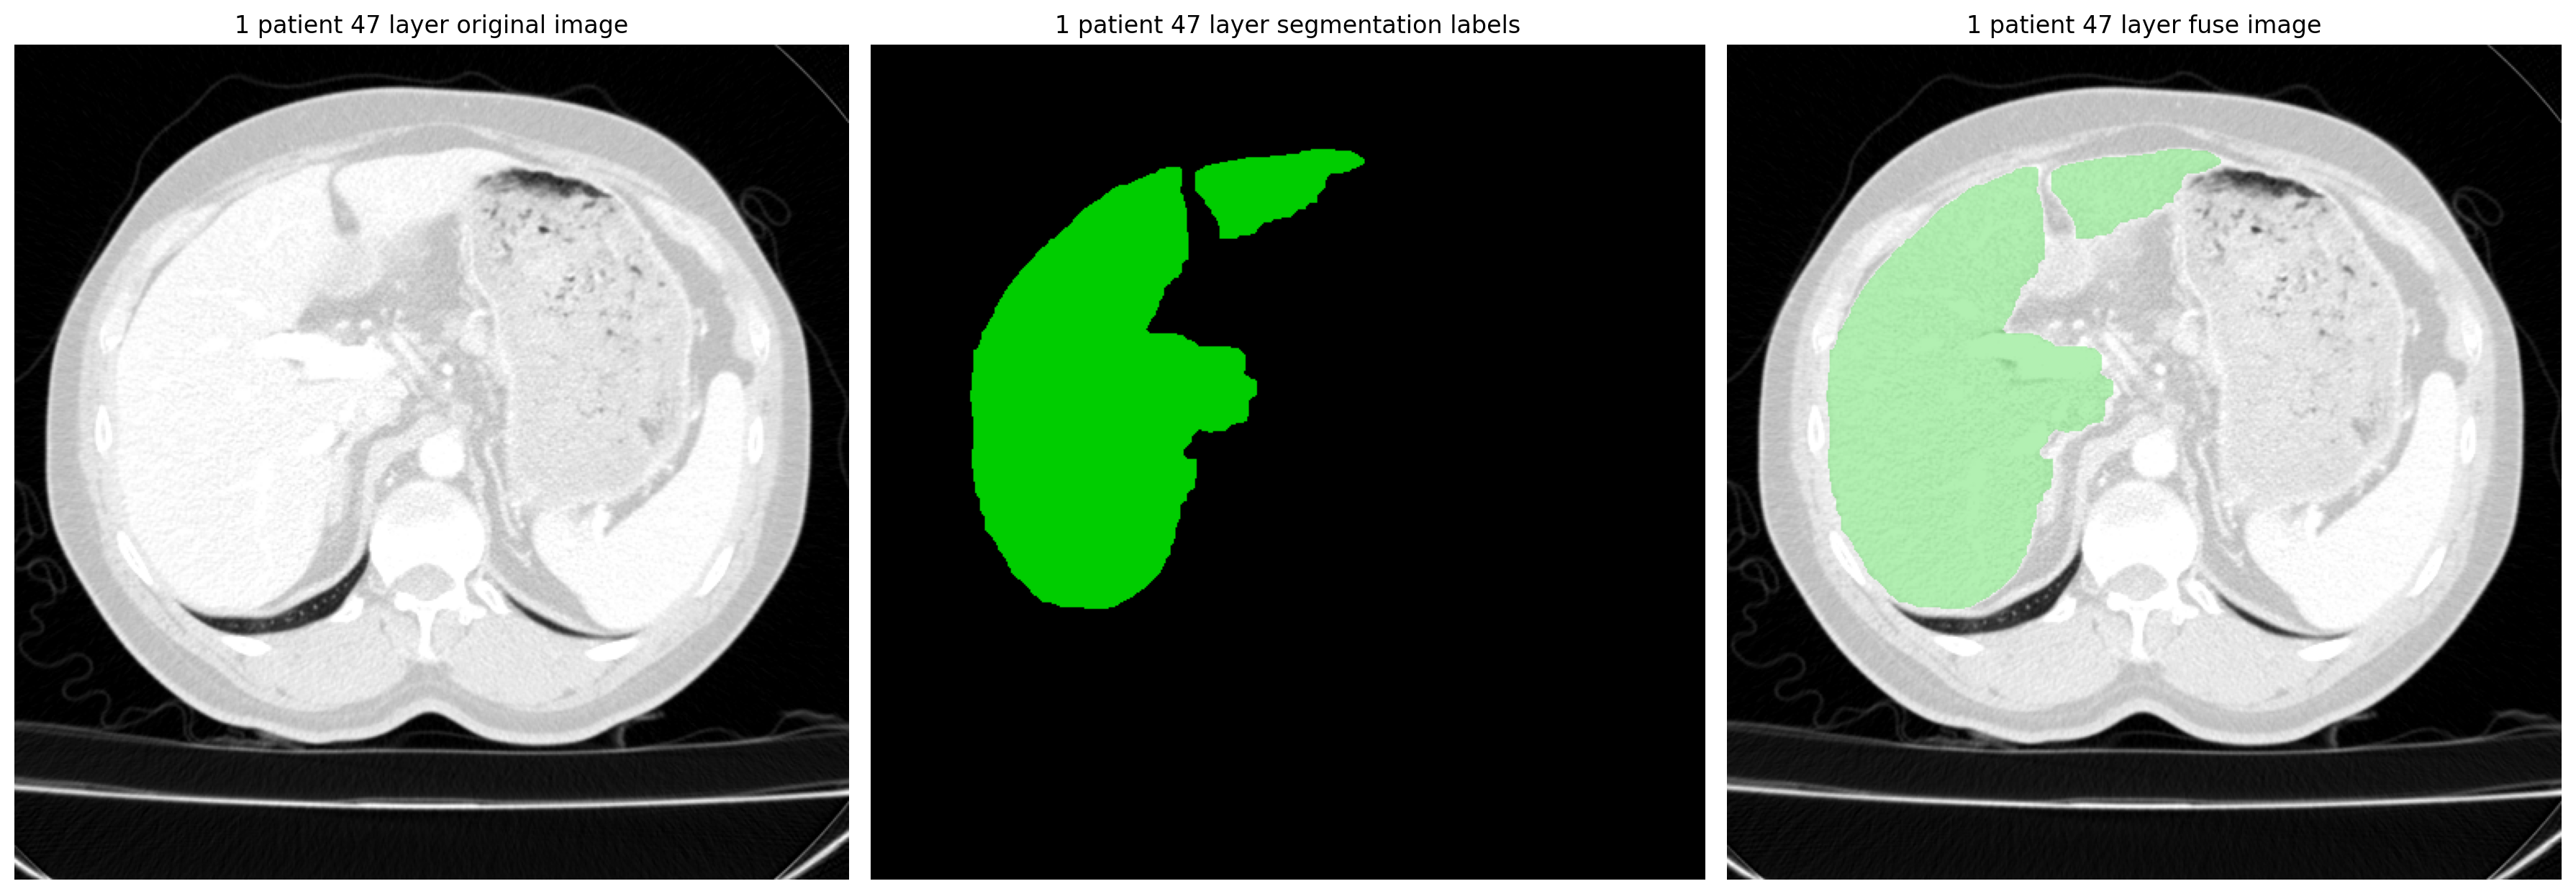

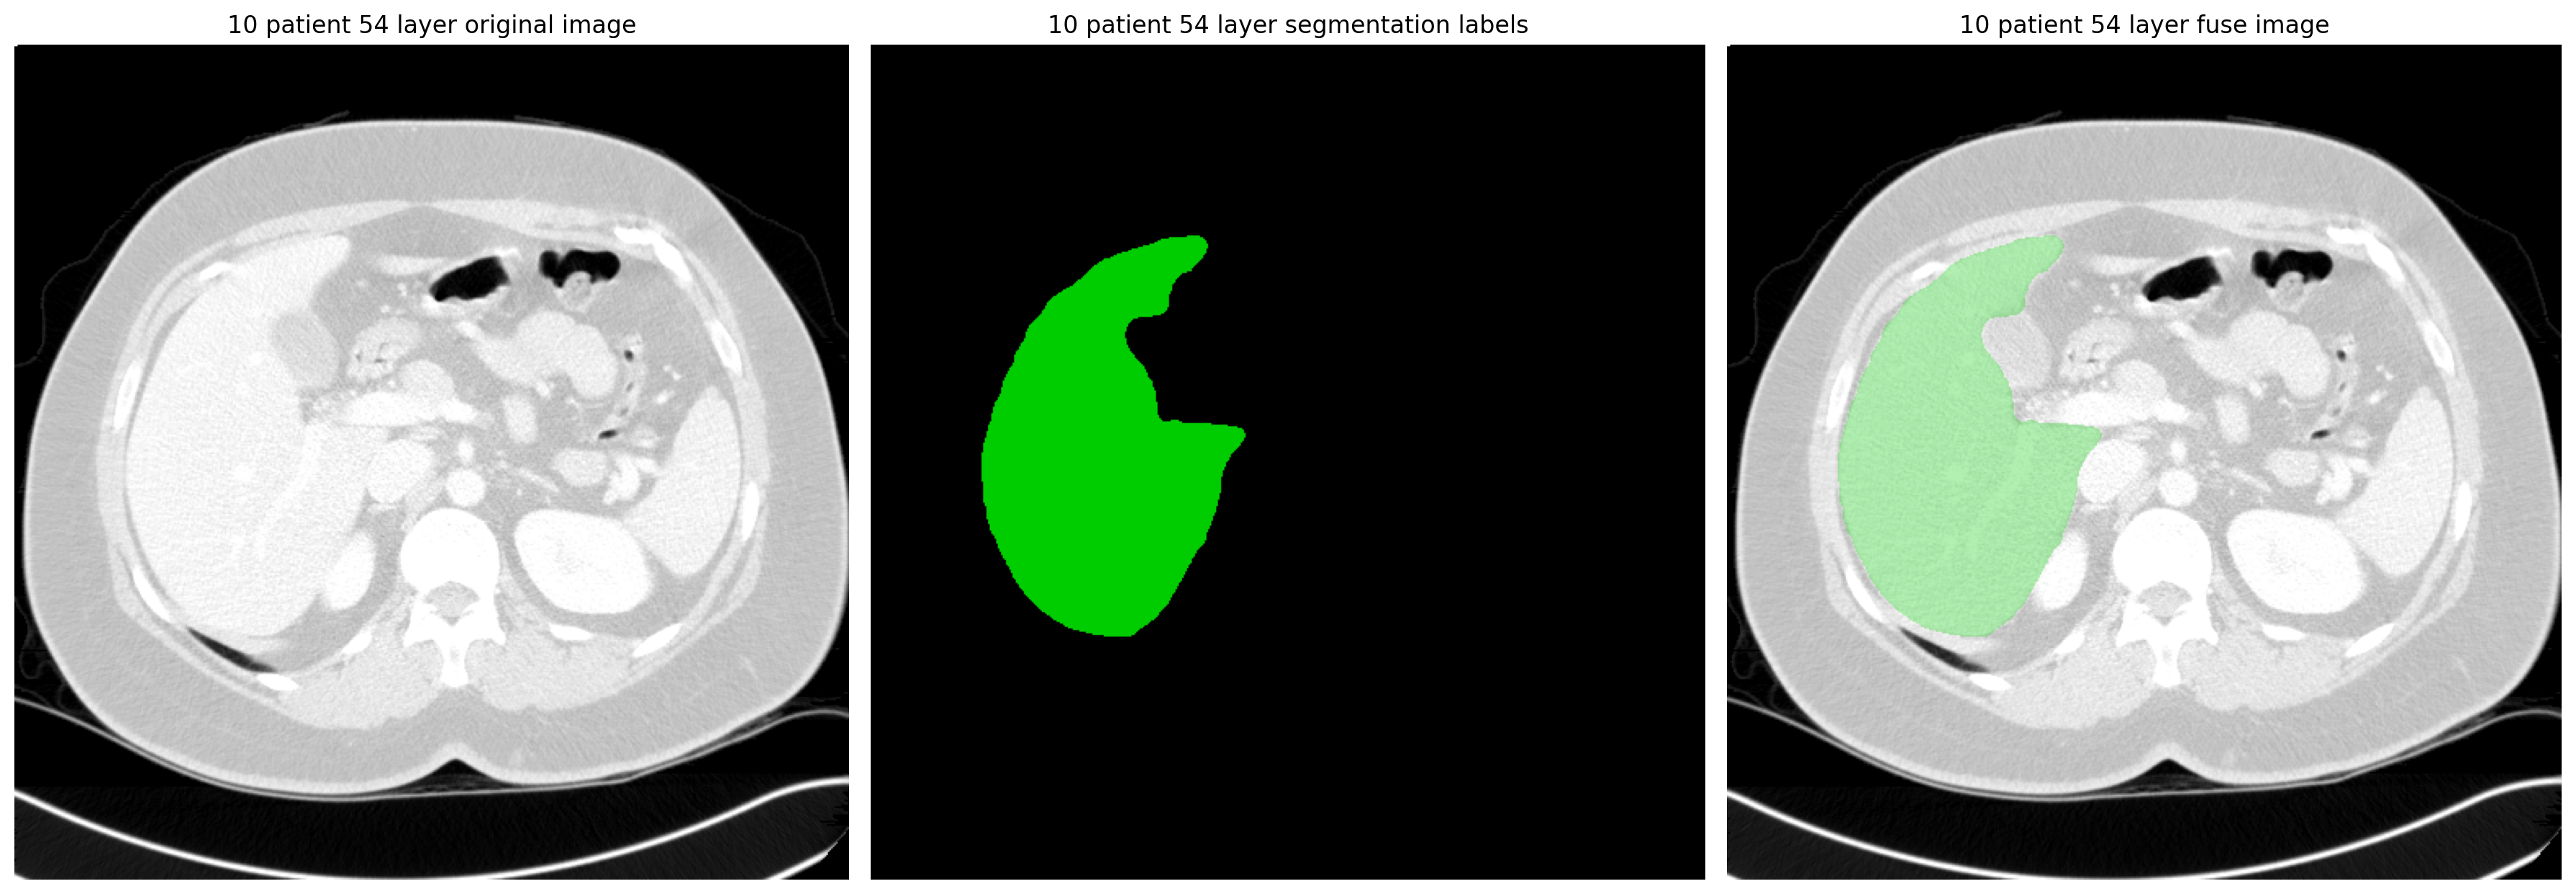

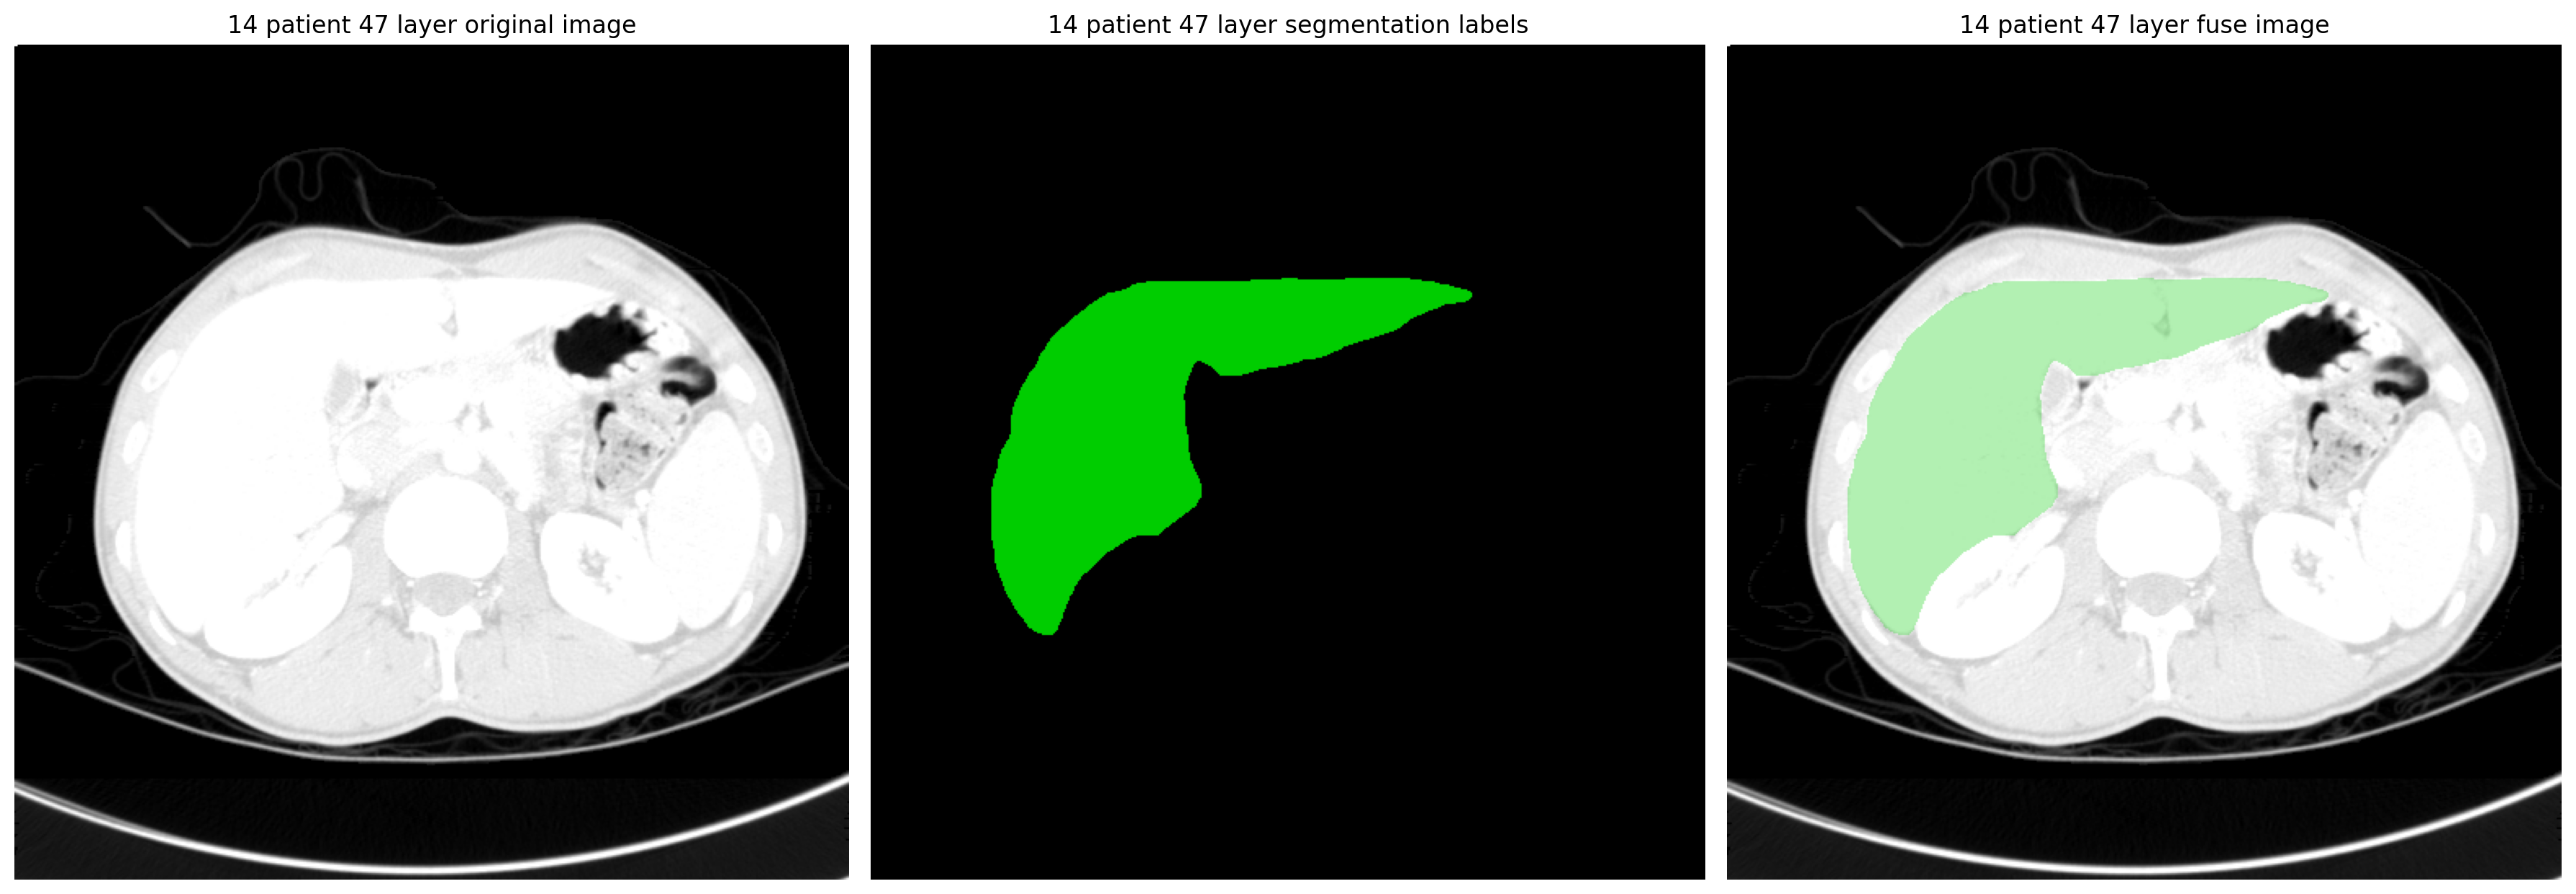

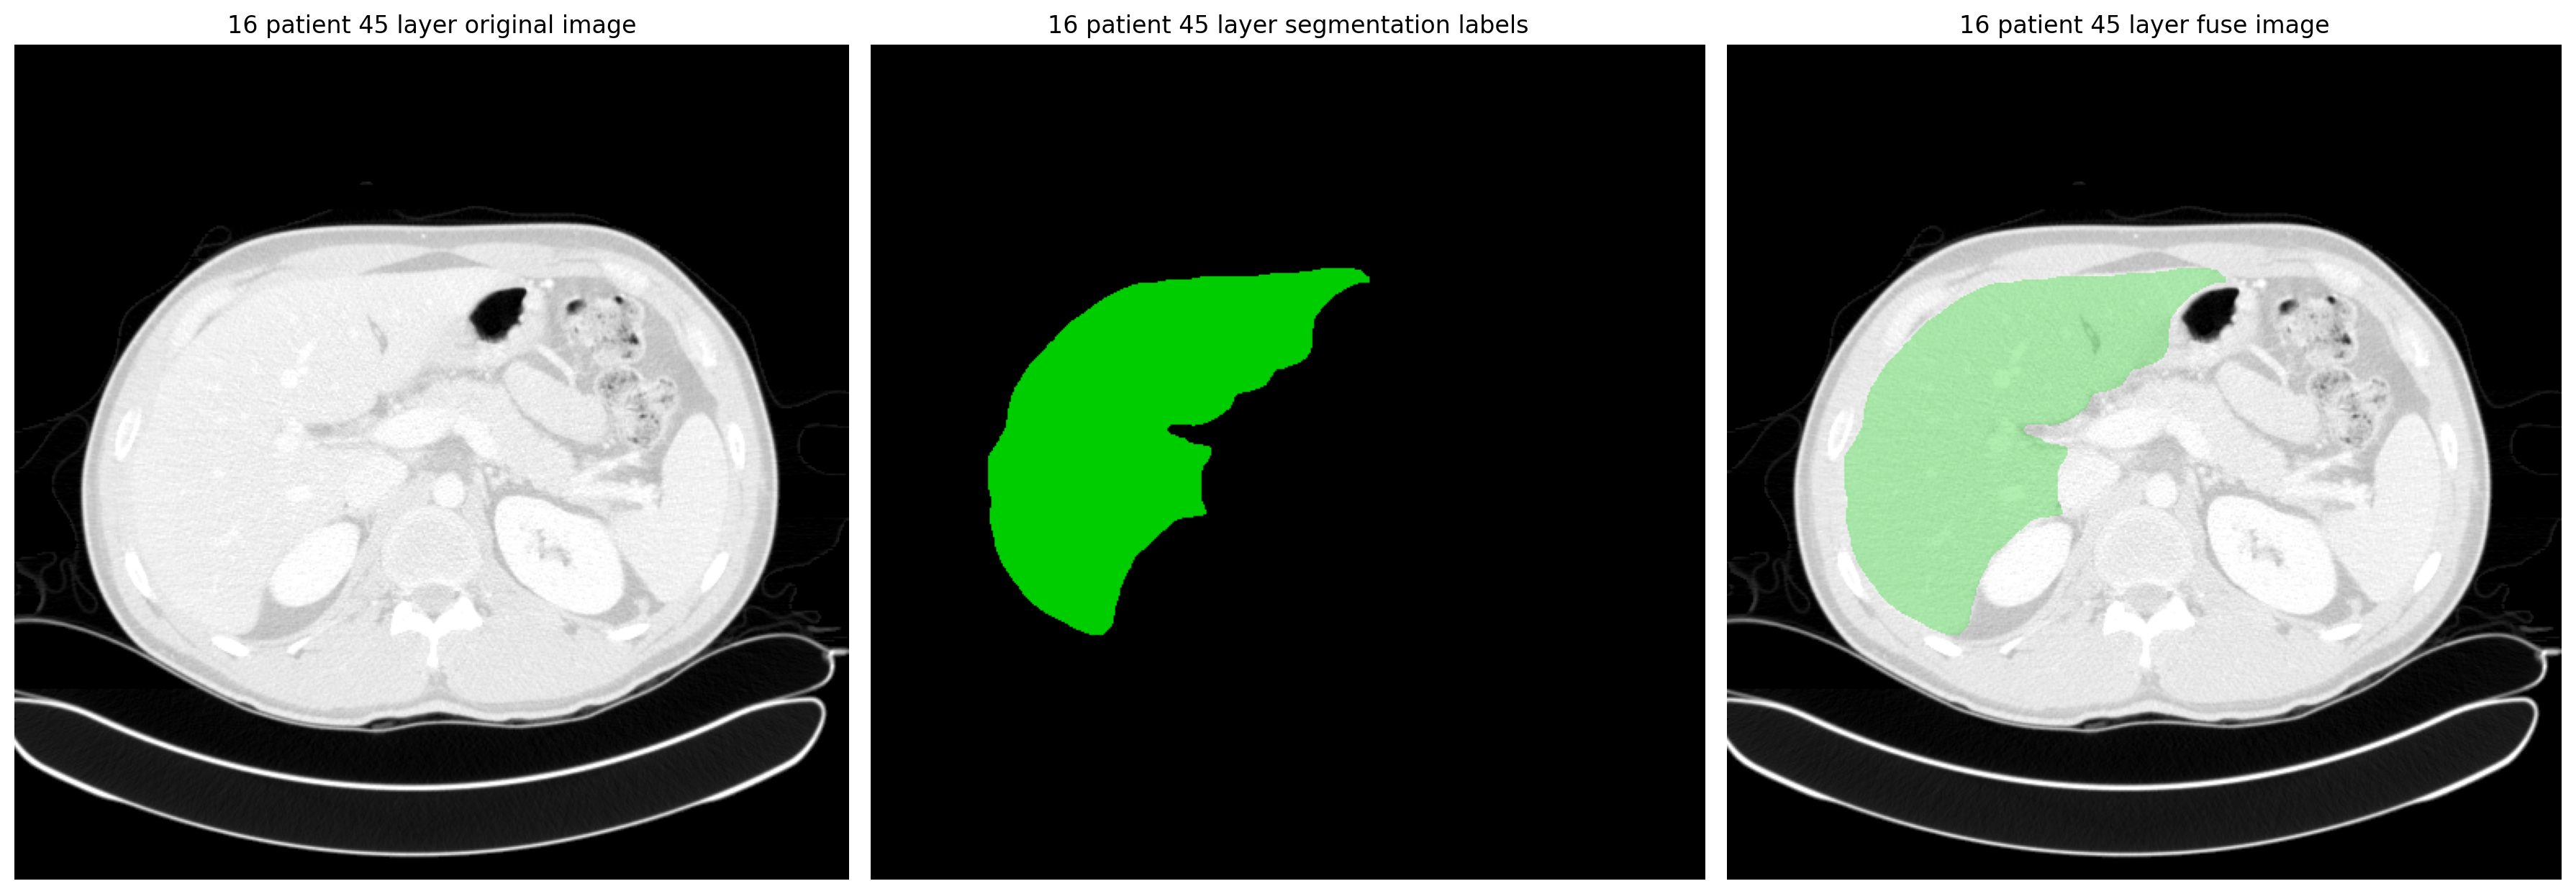

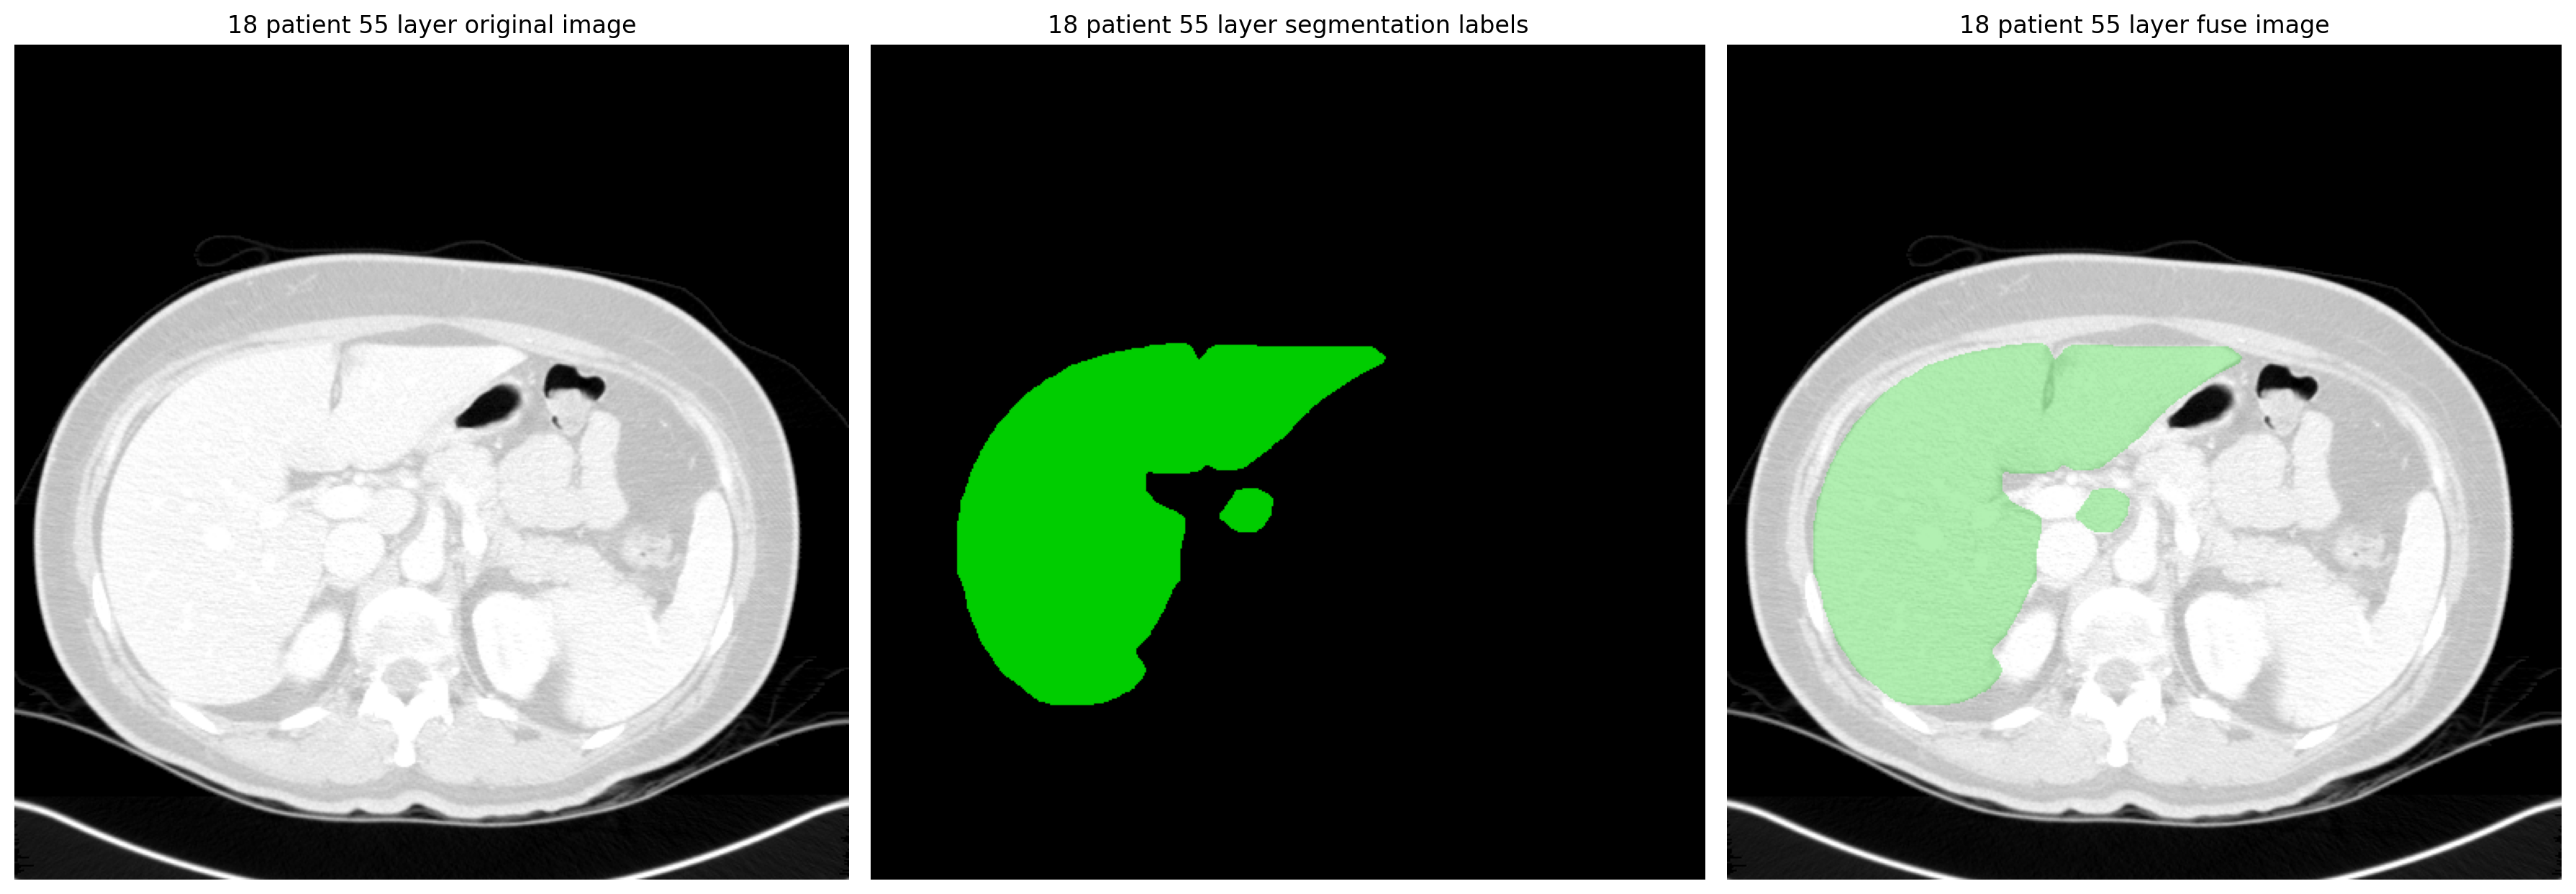

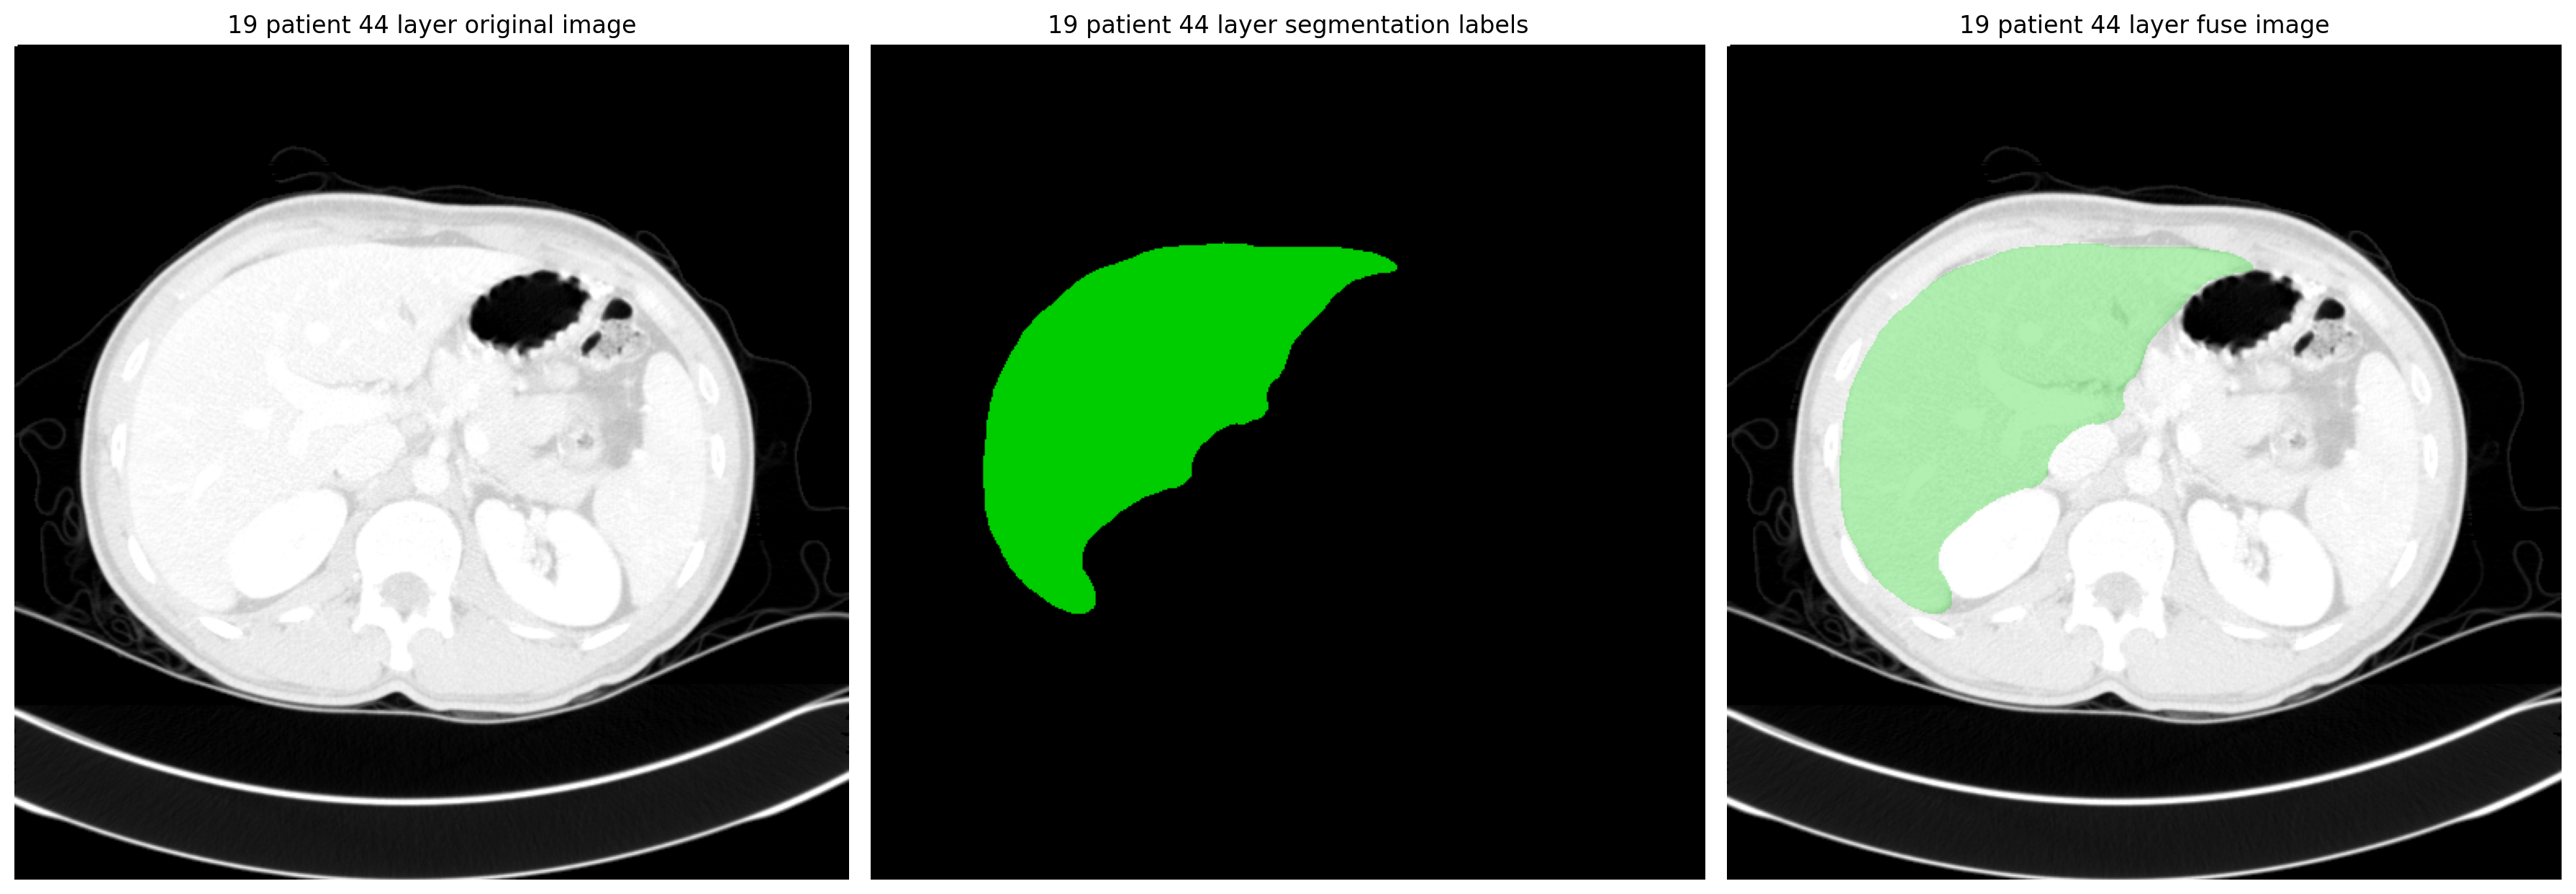

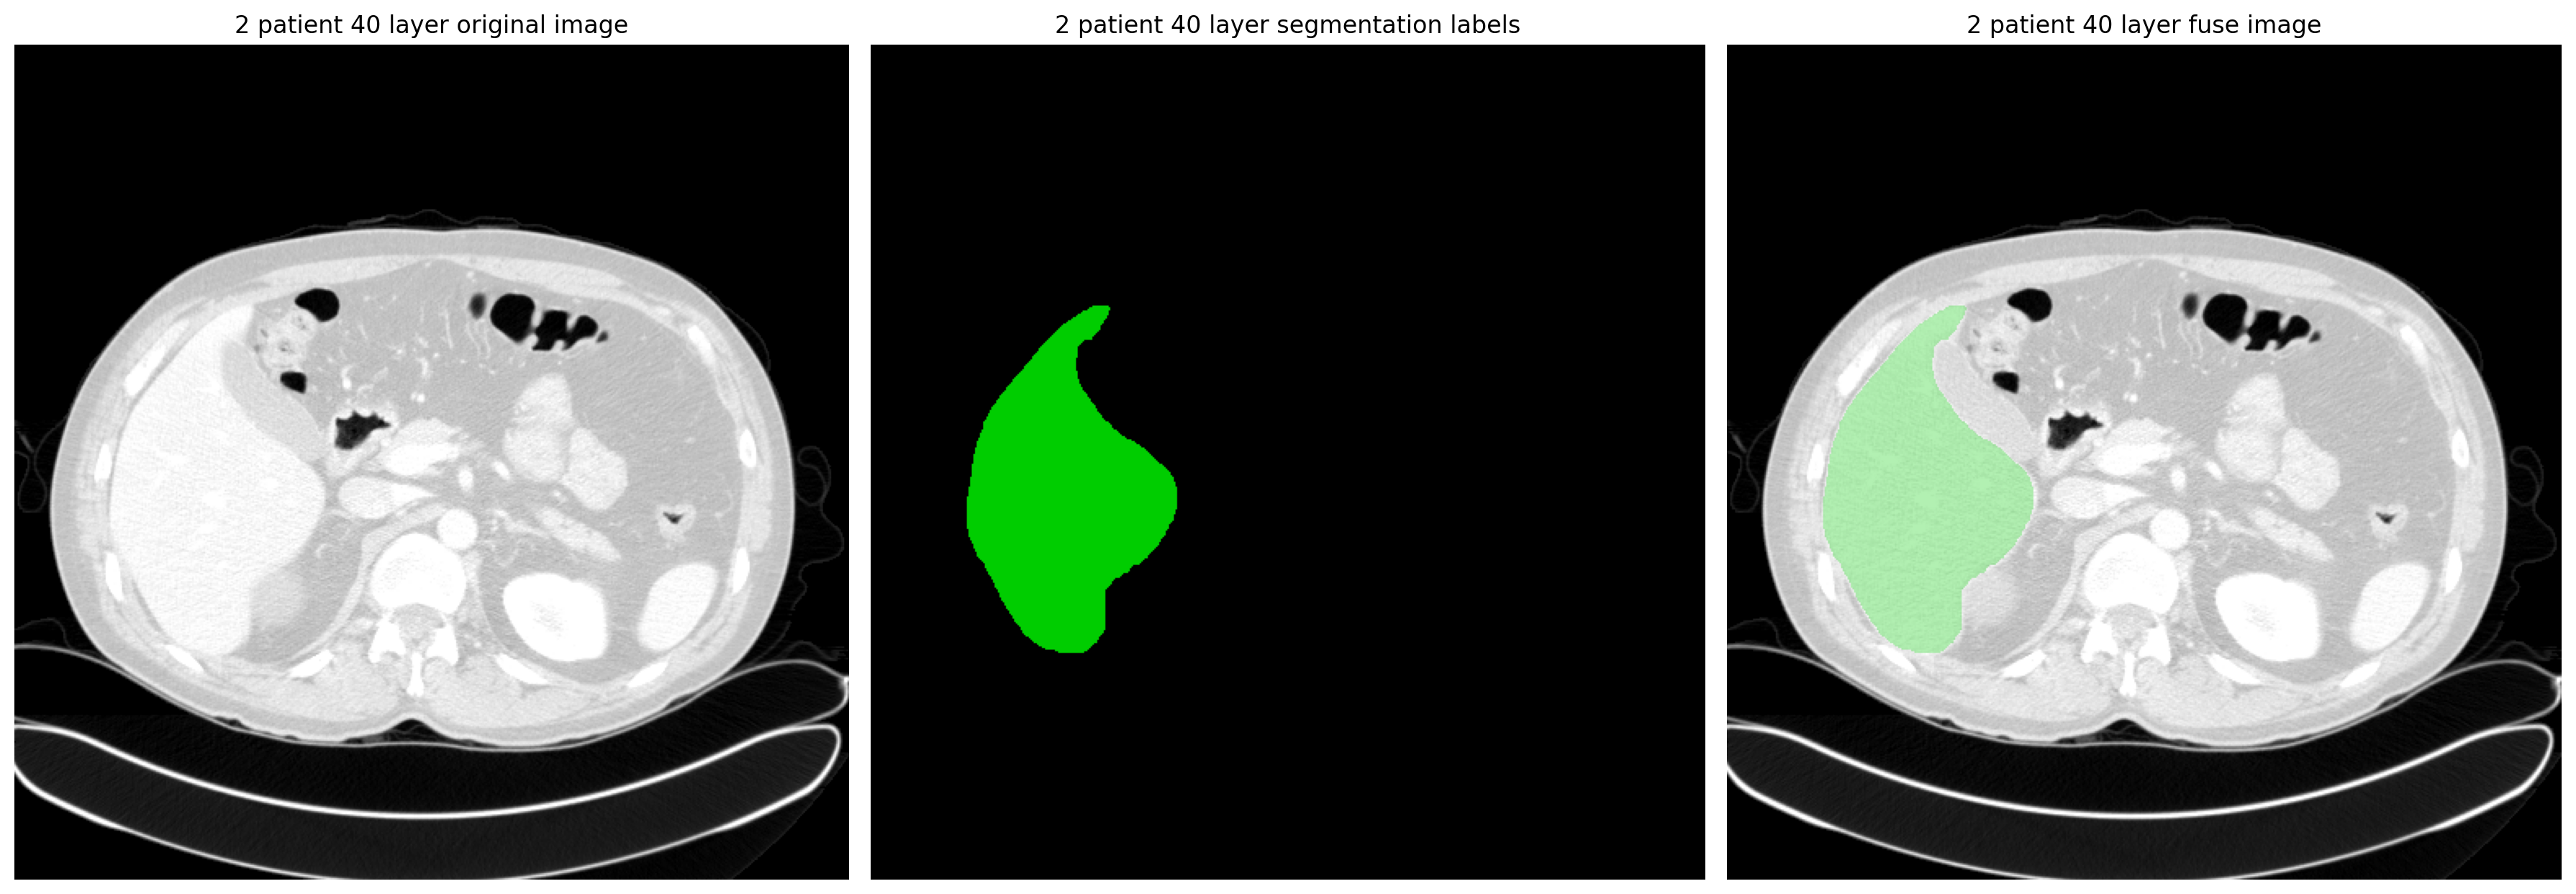

In [6]:
root = Path(r"C:\Users\orfu\Desktop\MyData\BaiduSyncdisk\研究方向\小样本学习\数据集\CHAOS\CHAOS_Train_Sets\Train_Sets\CT")
feature_path = Path(r"C:\Users\orfu\Desktop\MyData\BaiduSyncdisk\课程\大数据分析与实践\作业2\output")
feature_dict = dict()

for patient in os.listdir(root):
    dicom_folder = root / patient / "DICOM_anon"
    mask_folder = root / patient / "Ground"
    
    ct_ndarray, ct_image = loadDcm(dicom_folder)
    mask_ndarray = laodMask(mask_folder).astype(int)
    mask_image = sitk.GetImageFromArray(mask_ndarray)
    mask_image.CopyInformation(ct_image)

    Mydisplay(patient, ct_image, mask_image)
    print(f"patient: {patient}, \tct shape: {ct_ndarray.shape}, \tmask shape: {mask_ndarray.shape}")

In [10]:
feature_pd = pd.DataFrame()

for patient in os.listdir(root):
    dicom_folder = root / patient / "DICOM_anon"
    mask_folder = root / patient / "Ground"
    
    # load data
    ct_ndarray, ct_image = loadDcm(dicom_folder)

    mask_ndarray = laodMask(mask_folder).astype(int)
    mask_image = sitk.GetImageFromArray(mask_ndarray)
    mask_image.CopyInformation(ct_image)

    verse_mask_ndarray = np.logical_not(laodMask(mask_folder)).astype(int)
    verse_mask_image = sitk.GetImageFromArray(verse_mask_ndarray)
    verse_mask_image.CopyInformation(ct_image)

    print(f"patient: {patient}, \tct shape: {ct_ndarray.shape}, \tmask shape: {mask_ndarray.shape}")
        
    # construct feature extraction
    setting = {"normalization": True}
    extractor = featureextractor.RadiomicsFeatureExtractor(**setting)
    extractor.disableAllFeatures()
    # extractor.enableFeatureClassByName('firstorder')  有bug
    extractor.enableFeatureClassByName('glcm')
    extractor.enableFeatureClassByName('glrlm')
    

    # extract liver features and set their class to 0
    liver_features = extractor.execute(ct_image, mask_image)
    # delete metadata
    liver_features = {key: value for key, value in liver_features.items() if key.startswith('original_')}
    liver_features["label"] = 1
    # add data to dataframe
    liver_features_series = pd.Series(liver_features, name=f"{patient} liver")
    feature_pd = feature_pd._append(liver_features_series)

    # extract other organ features and set their class to 0    !!! error when extract patient 14! !!!
    verse_liver_features = extractor.execute(ct_image, verse_mask_image)
    # delete metadata
    verse_liver_features = {key: value for key, value in verse_liver_features.items() if key.startswith('original_')}
    verse_liver_features["label"] = 0
    # add data to dataframe
    verse_liver_features_series = pd.Series(verse_liver_features, name=f"{patient} other organ")
    feature_pd = feature_pd._append(verse_liver_features_series)

    feature_pd.to_csv(feature_path / "features.csv")

patient: 1, 	ct shape: (96, 512, 512), 	mask shape: (96, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 10, 	ct shape: (110, 512, 512), 	mask shape: (110, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 14, 	ct shape: (95, 512, 512), 	mask shape: (95, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 16, 	ct shape: (91, 512, 512), 	mask shape: (91, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 18, 	ct shape: (111, 512, 512), 	mask shape: (111, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 19, 	ct shape: (90, 512, 512), 	mask shape: (90, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 2, 	ct shape: (81, 512, 512), 	mask shape: (81, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 21, 	ct shape: (257, 512, 512), 	mask shape: (257, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 22, 	ct shape: (101, 512, 512), 	mask shape: (101, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 23, 	ct shape: (240, 512, 512), 	mask shape: (240, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 24, 	ct shape: (123, 512, 512), 	mask shape: (123, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 25, 	ct shape: (235, 512, 512), 	mask shape: (235, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 26, 	ct shape: (114, 512, 512), 	mask shape: (114, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 27, 	ct shape: (242, 512, 512), 	mask shape: (242, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 28, 	ct shape: (102, 512, 512), 	mask shape: (102, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 29, 	ct shape: (214, 512, 512), 	mask shape: (214, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 30, 	ct shape: (266, 512, 512), 	mask shape: (266, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 5, 	ct shape: (95, 512, 512), 	mask shape: (95, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 6, 	ct shape: (88, 512, 512), 	mask shape: (88, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


patient: 8, 	ct shape: (123, 512, 512), 	mask shape: (123, 512, 512)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [ ]:
# 计算像素点和分类标签的相关性，没啥用
correlation_matrix = pd.DataFrame(columns=['Patient', 'Correlation', 'p-value'])
for patient in os.listdir(root):
    dicom_folder = root / patient / "DICOM_anon"
    mask_folder = root / patient / "Ground"
    
    ct_ndarray, ct_image = loadDcm(dicom_folder)
    mask_ndarray = laodMask(mask_folder).astype(int)

    print(f"patient: {patient}, \tct shape: {ct_ndarray.shape}, \tmask shape: {mask_ndarray.shape}")
    
    # 将三维 ndarray 转换为一维数组
    flat_array = ct_ndarray.flatten()
    mask_array = mask_ndarray.flatten()

    # 计算最高5%和最低2%的百分位数
    lower_percentile = np.percentile(flat_array, 5)
    upper_percentile = np.percentile(flat_array, 98)
    
    # 将最高5%和最低5%的数据转换为最高值和最低值
    filtered_array = np.where(flat_array < lower_percentile, lower_percentile, flat_array)
    filtered_array = np.where(filtered_array > upper_percentile, upper_percentile, filtered_array)
    filtered_array = np.random.randint(100, size=mask_array.shape)

    # 计算连续变量和二分类变量的相关性
    correlation, p_value = pointbiserialr(mask_array, filtered_array)
    correlation_matrix = correlation_matrix._append({'Patient': patient, 'Correlation': correlation, 'p-value': p_value}, ignore_index=True)

# 打印结果
correlation_matrix.to_csv(feature_path / "pixel&mask.csv")

patient: 1, 	ct shape: (96, 512, 512), 	mask shape: (96, 512, 512)
[53 66 70 ... 36 12 72]
False
patient: 10, 	ct shape: (110, 512, 512), 	mask shape: (110, 512, 512)
[52 10 75 ...  6 50 50]
False
patient: 14, 	ct shape: (95, 512, 512), 	mask shape: (95, 512, 512)
[27 93  8 ... 59 65 72]
False
patient: 16, 	ct shape: (91, 512, 512), 	mask shape: (91, 512, 512)
[77 14 93 ... 73 57 85]
False
patient: 18, 	ct shape: (111, 512, 512), 	mask shape: (111, 512, 512)
[75 99 97 ... 98 67 59]
False
patient: 19, 	ct shape: (90, 512, 512), 	mask shape: (90, 512, 512)
[73  3 17 ... 21 47 84]
False
patient: 2, 	ct shape: (81, 512, 512), 	mask shape: (81, 512, 512)
[94 41 18 ... 45 67 96]
False
patient: 21, 	ct shape: (257, 512, 512), 	mask shape: (257, 512, 512)
[16 75 68 ...  2 93 55]
False
patient: 22, 	ct shape: (101, 512, 512), 	mask shape: (101, 512, 512)
[99  7 53 ... 76 22 14]
False
patient: 23, 	ct shape: (240, 512, 512), 	mask shape: (240, 512, 512)
[28 57 67 ... 93 66 28]
False
patient: 24,